In [1]:
import os
import pandas as pd

In [3]:
folder_path = "data"  # Change this to your actual folder path

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

if not csv_files:
    raise ValueError("No CSV files found in the folder!")

dataframes = []

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        print(f"Reading file: {file}...")  
        df = pd.read_csv(file_path, dtype=str)  # Read as string to avoid datatype mismatches
        if not df.empty:
            df["source_file"] = file  # Add a column to track file origin
            dataframes.append(df)
        else:
            print(f"Skipping empty file: {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not dataframes:
    raise ValueError("No valid data found in any file!")

# Merge all DataFrames
final_df = pd.concat(dataframes, ignore_index=True)

# Save as a new CSV for further processing
final_df.to_csv("combined_data.csv", index=False)

print("✅ Data successfully merged and saved as combined_data.csv")
print(final_df.info())


Reading file: fixed_gear.csv...
Reading file: pole_and_line.csv...
Reading file: purse_seines.csv...
Reading file: trawlers.csv...
Reading file: trollers.csv...
✅ Data successfully merged and saved as combined_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801119 entries, 0 to 7801118
Data columns (total 11 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   mmsi                 object
 1   timestamp            object
 2   distance_from_shore  object
 3   distance_from_port   object
 4   speed                object
 5   course               object
 6   lat                  object
 7   lon                  object
 8   is_fishing           object
 9   source               object
 10  source_file          object
dtypes: object(11)
memory usage: 654.7+ MB
None


In [4]:
import pandas as pd

# Load the combined CSV
df = pd.read_csv("combined_data.csv")

# Display basic info
print(df.info())

# Display first few rows
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Drop rows with missing latitude or longitude (critical for map-based models)
df.dropna(subset=["lat", "lon"], inplace=True)

# Convert necessary columns to correct data types
df["timestamp"] = pd.to_datetime(df["timestamp"])  # Convert to datetime
df["speed"] = pd.to_numeric(df["speed"], errors='coerce')  # Convert speed to numeric
df["course"] = pd.to_numeric(df["course"], errors='coerce')
df["is_fishing"] = df["is_fishing"].astype(int)  # Ensure binary classification

# Save cleaned data
df.to_csv("cleaned_data.csv", index=False)
print("✅ Data cleaned and saved as cleaned_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801119 entries, 0 to 7801118
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
 10  source_file          object 
dtypes: float64(9), object(2)
memory usage: 654.7+ MB
None
           mmsi     timestamp  distance_from_shore  distance_from_port  speed  \
0  7.572519e+12  1.347664e+09                  0.0        36054.625000    0.0   
1  7.572519e+12  1.348056e+09                  0.0        36054.625000    0.0   
2  7.572519e+12  1.350409e+09                  0.0        90970.296875    0.0   
3  7.572519e+12  1.350410e+09                  0.0        9097

In [8]:
df["hour"] = df["timestamp"].dt.hour  # Time-based features
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month

df["speed_category"] = pd.cut(df["speed"], bins=[0, 2, 5, 10, 50], labels=["Very Slow", "Slow", "Medium", "Fast"])

df.to_csv("processed_data.csv", index=False)
print("✅ Processed data saved as processed_data.csv")


✅ Processed data saved as processed_data.csv


In [2]:
%pip install pandas numpy scikit-learn xgboost folium matplotlib seaborn flask fastapi uvicorn geopandas


  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached folium-0.19.5-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached uvicorn-0.34.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached starlette-0.46.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached pyogrio-0.10.0-cp312-cp312-wi


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [4]:
# Load the cleaned dataset
df = pd.read_csv("processed_data.csv")

# Select features and target
features = ["speed", "course", "distance_from_shore", "distance_from_port", "hour", "day_of_week", "month"]
target = "is_fishing"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


In [6]:
# Convert target labels: Change -1 to 0
df["is_fishing"] = df["is_fishing"].replace(-1, 0)

# Re-run the train-test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df["is_fishing"], test_size=0.2, random_state=42)


In [7]:
# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Model Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))



✅ XGBoost Model Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1544416
           1       0.69      0.09      0.16     15808

    accuracy                           0.99   1560224
   macro avg       0.84      0.55      0.58   1560224
weighted avg       0.99      0.99      0.99   1560224



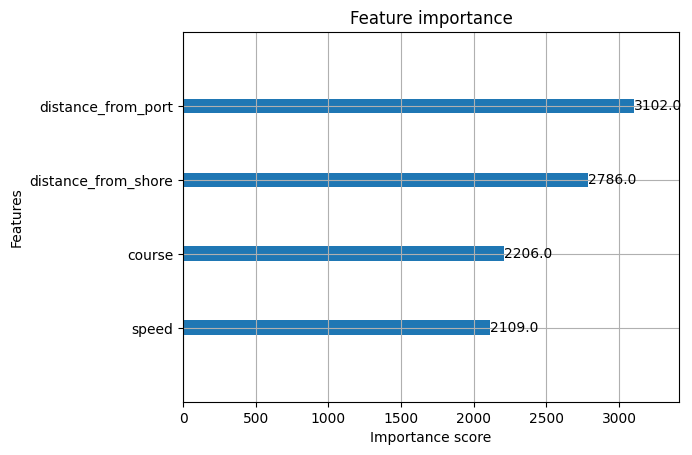

In [8]:
import matplotlib.pyplot as plt

# Get feature importance
xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10)
plt.show()


In [9]:
import joblib

# Save the trained model
joblib.dump(xgb_model, "fishing_zone_model.pkl")
print("✅ Model saved as fishing_zone_model.pkl")

✅ Model saved as fishing_zone_model.pkl
